<a href="https://colab.research.google.com/github/Jade2121/CS777CourseProject/blob/master/CS777_final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Proposal

Olist in Brazil empowers small merchants to sell online. Brazils complex collection of merchants opened an opportunity for Olist to provide a similar service to the region like Walmart in USA. They provide support to merchants by managing all aspects of product retail from product catelog to payments. For users in Brazil they are able to come to one place to access the diverse marketplaces of the region. However, an immediate challenge in creating such a market is connecting users to the products they are looking for and helping sellers find the right users for their products. The solution to this problem is to implement a recommendation system, which this project will seek to create. 

#Approach

Machine learning has provided us with the opportunity to improve sales of retailers using remmonendation systems. Netflix's recommendation system has an RMSE of 0.8.Collaborative techniques use user history to suggest items by finding where users preferences overlap. If two users happen to share purchase history for two items, there could be a third item that one user bought that could be recommended to the other. With enough users and purchase history this can be a very effective approach, but unfortunately it does not predict well for new users. Content based filtering techniques can use user information along with item information to suggest based on a number of factors. Combining these two helps to create accurate predictions for current users and relevant predictions for new users.

# Enviroment Configuration

In [ ]:
#Install spark
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" 
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2" 


# install findspark using pip
!pip install -q findspark


^C


In [ ]:
#!rm spark-3.0.0-bin-hadoop3.2.tgz
#!pip uninstall pyspark
!pip install pyspark

     |████████████████████████████████| 281.4 MB 48 kB/s 
     |████████████████████████████████| 198 kB 79.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=37d5ecce6afbd1e8c9f3c4aa170b9a445a5aad972ec0018052b78ba8afc581eb
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
!ls -a 

.   .config	 spark-3.0.0-bin-hadoop3.2
..  sample_data  spark-3.0.0-bin-hadoop3.2.tgz


**Goal**: sentiment analysis of the customer review

# Data preparation(Sentiment analysis)

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer, \
           StopWordsRemover, NGram, HashingTF, IDF, Word2Vec

from pyspark.sql.functions import explode, expr
from pyspark.ml.functions  import vector_to_array

In [ ]:
#imports
from google.colab import files
from pyspark import SparkContext 
from pyspark.sql.functions import expr
from pyspark.sql.functions import col,isnan,when,count
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import monotonically_increasing_id
import nltk


In [ ]:
!pwd

/content


In [ ]:
#load google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#init spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(
    "TextProcessing").getOrCreate()
spark


[link text](https://)https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv

About our data set:
Brazilian E-Commerce Public Dataset by Olist

In [ ]:
schema = 'review_comment_message string, review_score double'
#spark dataframe
df=spark.read.csv('./drive/MyDrive/CS777_PROJECT/Colab_Notebooks/Data_set/retail_dataset_review.csv',schema = schema,
                  header=True,sep=',') #,header=True, inferSchema=True,sep=',', multiLine=True,
df.printSchema()
#RDD
#data=sc.textFile("../drive/../retail_dataset.csv")
#data=data.map(lambda x:x.split(","))

root
 |-- review_comment_message: string (nullable = true)
 |-- review_score: double (nullable = true)



In [ ]:
#size of our data
df.count()

123553

In [ ]:
df.show()

+----------------------+------------+
|review_comment_message|review_score|
+----------------------+------------+
|  Não testei o prod...|         4.0|
|  Não testei o prod...|         4.0|
|  Não testei o prod...|         4.0|
|  Muito bom o produto.|         4.0|
|                  null|         5.0|
|  O produto foi exa...|         5.0|
|                  null|         5.0|
|                  null|         4.0|
|  fiquei triste por...|         2.0|
|                  null|         5.0|
|                  null|         1.0|
|                  null|         5.0|
|                  null|         5.0|
|  Aguardando retorn...|         1.0|
|  Aguardando retorn...|         1.0|
|                  null|         4.0|
|                  null|         5.0|
|                  null|         5.0|
|     Gostei do produto|         4.0|
|  Obrigado pela ate...|         5.0|
+----------------------+------------+
only showing top 20 rows



In [ ]:
#find na value of review_comment_message

#count number NA values
df.filter(df.review_comment_message.isNull()).count()

67651

In [ ]:
#data cleaning
#exclude na row
clean_df = df.filter(df.review_comment_message.isNotNull())
clean_df = clean_df.filter(clean_df.review_score.isNotNull())
#exclude 0 review scores
clean_df = clean_df.filter(clean_df.review_score != 0 )
#drop the replicated rows
clean_df = clean_df.distinct()
#add id col
clean_df = clean_df.withColumn("id", 1+monotonically_increasing_id())
clean_df.show(4)

+----------------------+------------+---+
|review_comment_message|review_score| id|
+----------------------+------------+---+
|  Qualidade interme...|         5.0|  1|
|  Produto correto, ...|         4.0|  2|
|  estou muito satis...|         5.0|  3|
|  Já comprei vários...|         1.0|  4|
+----------------------+------------+---+
only showing top 4 rows



In [ ]:
clean_df.groupBy(clean_df.review_score).count().show()

+------------+-----+
|review_score|count|
+------------+-----+
|         1.0| 7609|
|         4.0| 5063|
|         3.0| 3179|
|         2.0| 1975|
|         5.0|16560|
+------------+-----+



# **words transformation and deletion**

As long as we consider the global internet as the source of our comments, probably we have to deal with some HTML tags, break lines, special characteres and other content that could be part of the dataset.

In [ ]:
import re
#comment and its scores
clean_df.show(10, truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+---+
|review_comment_message                                                                                                                                                                               |review_score|id |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+---+
|Qualidade intermediária                                                                                                                                                                              |5.0         |1  |
|Produto correto, entregue no prazo, preço bom.                                                                                     

In [ ]:
#get rdd then use map function to map and transform data
Rdd_clean_df = clean_df.rdd.map(tuple)


In [ ]:
#example of RDD
Rdd_clean_df.take(2)

[('Qualidade intermediária', 5.0, 1),
 ('Produto correto, entregue no prazo, preço bom.', 4.0, 2)]

In [ ]:
#first step, replace Sites and Hiperlinks to word:"link"
def re_hiperlinks(text):
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(pattern, ' link ', text)

Rdd_clean_df = Rdd_clean_df.map(lambda row: (re_hiperlinks(row[0]), row[1], row[2]))
Rdd_clean_df.take(2)

[('Qualidade intermediária', 5.0, 1),
 ('Produto correto, entregue no prazo, preço bom.', 4.0, 2)]

In [ ]:
#second step, replace any Dates to word:"data"(which means date in english)

def re_dates(text):
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return re.sub(pattern, ' data ', text)


Rdd_clean_df = Rdd_clean_df.map(lambda row: (re_dates(row[0]), row[1], row[2]))
Rdd_clean_df.take(2)

[('Qualidade intermediária', 5.0, 1),
 ('Produto correto, entregue no prazo, preço bom.', 4.0, 2)]

In [ ]:
#third step, replace any Money value to word:"dinheiro"(which means money in english)
def re_money(text):   
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return re.sub(pattern, ' dinheiro ', text)
  

Rdd_clean_df = Rdd_clean_df.map(lambda row: (re_money(row[0]), row[1], row[2]))
Rdd_clean_df.take(2)

[('Qualidade intermediária', 5.0, 1),
 ('Produto correto, entregue no prazo, preço bom.', 4.0, 2)]

In [ ]:
#fourth step, replace any Numbers to word:"numero"(which means number in english)
def re_numbers(text):
    
    # Applying regex
    return re.sub('[0-9]+', ' numero ', text)

Rdd_clean_df = Rdd_clean_df.map(lambda row: (re_numbers(row[0]), row[1], row[2]))
Rdd_clean_df.take(2)

[('Qualidade intermediária', 5.0, 1),
 ('Produto correto, entregue no prazo, preço bom.', 4.0, 2)]

In [ ]:
#fifth step, replace any Negation words to word:"negação "(which means "denial" in english)
def re_negation(text):
    # Applying regex
    return re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', text)

Rdd_clean_df = Rdd_clean_df.map(lambda row: (re_negation(row[0]), row[1], row[2]))
Rdd_clean_df.take(2)

[('Qualidade intermediária', 5.0, 1),
 ('Produto correto, entregue no prazo, preço bom.', 4.0, 2)]

In [ ]:
#sixth step, remove any special characters, e.g. emoji

def re_special_chars(text):

    # Applying regex
    return re.sub('\W', ' ', text)

Rdd_clean_df = Rdd_clean_df.map(lambda row: (re_special_chars(row[0]), row[1], row[2]))
Rdd_clean_df.take(2)

[('Qualidade intermediária', 5.0, 1),
 ('Produto correto  entregue no prazo  preço bom ', 4.0, 2)]

In [ ]:
#convert from rdd back to df
schema = 'review_comment_message string, review_score double, id int'
clean_df = Rdd_clean_df.toDF(['review_comment_message','review_score','id'])
clean_df.show()

+----------------------+------------+---+
|review_comment_message|review_score| id|
+----------------------+------------+---+
|  Qualidade interme...|         5.0|  1|
|  Produto correto  ...|         4.0|  2|
|  estou muito satis...|         5.0|  3|
|  Já comprei vários...|         1.0|  4|
|           Ótimo site |         4.0|  5|
|   Produto mal acabado|         2.0|  6|
|  Gostei muito do p...|         5.0|  7|
|  Muito bom  Recome...|         5.0|  8|
|  COPRA VEIO ERRADA...|         1.0|  9|
|  MUITO BOA A LOGÍS...|         4.0| 10|
|  Comprei o telefon...|         4.0| 11|
|   negação  recebi ...|         1.0| 12|
|                    ok|         4.0| 13|
|  produto chegou er...|         1.0| 14|
|  A descrição do pr...|         1.0| 15|
|  Dentro do anuncia...|         4.0| 16|
|  Recomendo  Pois o...|         5.0| 17|
|  Muito boa a mala ...|         5.0| 18|
|  Produto bom entre...|         5.0| 19|
|  A Loja  negação  ...|         1.0| 20|
+----------------------+----------

In [ ]:
#tokenization

tokenizer = RegexTokenizer(inputCol="review_comment_message", # tokenize reviews
                      outputCol="words",
                       pattern= "\\W")
wordsdata = tokenizer.transform(clean_df)

#wordsdata=tokenizer.transform(df).select(['review_comment_message','words'])
#wordsdata.show(truncate=True,vertical=True)

#wordsdata.select([count(when(isnan(i) | col(i).isNull(),i)).alias(i) for i in wordsdata.columns]).show() #count nulls

#wordsdata=wordsdata.dropna() #drop null values



In [ ]:
#Stemming
#def stemming_process(text, stemmer=RSLPStemmer()):

  #return ''.join([stemmer.stem(c)+' ' for c in text.split()])

#Rdd_clean_df = Rdd_clean_df.map(lambda row: (stemming_process(row[0]), row[1], row[2]))
#Rdd_clean_df.take(2)  

In [ ]:
#after tokenization
wordsdata.show(5,truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 review_comment_message | Qualidade intermediária                                                                                                                                                                                                                 
 review_score           | 5.0                                                                                                                                                                                                                                     
 id                     | 1                                                                                                                                                                                                    

In [ ]:
#remove stop words
#use default portuguese stop words

remover= StopWordsRemover(
    inputCol="words",
    outputCol="filteredWords",
    stopWords = StopWordsRemover.loadDefaultStopWords("portuguese")
)
noStopWords_df=remover.transform(wordsdata)
#noStopWords_df.select('filteredWords').take(1)

In [ ]:
noStopWords_df.show(2,truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------
 review_comment_message | Qualidade intermediária                              
 review_score           | 5.0                                                  
 id                     | 1                                                    
 words                  | [qualidade, intermedi, ria]                          
 filteredWords          | [qualidade, intermedi, ria]                          
-RECORD 1----------------------------------------------------------------------
 review_comment_message | Produto correto  entregue no prazo  preço bom        
 review_score           | 4.0                                                  
 id                     | 2                                                    
 words                  | [produto, correto, entregue, no, prazo, pre, o, bom] 
 filteredWords          | [produto, correto, entregue, prazo, pre, bom]        
only showing top 2 rows



In [ ]:

import nltk
nltk.download('rslp')
from nltk.stem import *
#stem words
def stem(in_vec,stemmer=RSLPStemmer()):
    out_vec = []
    for t in in_vec:
        t_stem = stemmer.stem(t)
        if len(t_stem) > 2:
            out_vec.append(t_stem)       
    return out_vec
# Create user defined function for stemming with return type Array<String>
from pyspark.sql.types import *
from pyspark.sql.functions import udf
stemmer_udf = udf(lambda x: stem(x), ArrayType(StringType()))

# Create new df with vectors containing the stemmed tokens 
word_stemmed_df = noStopWords_df.withColumn("word_stemmed", stemmer_udf("filteredWords"))#.select(['id','word_stemmed','review_score'])
#the dataset after stemming
word_stemmed_df.show(2,truncate=False, vertical=True)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
-RECORD 0----------------------------------------------------------------------
 review_comment_message | Qualidade intermediária                              
 review_score           | 5.0                                                  
 id                     | 1                                                    
 words                  | [qualidade, intermedi, ria]                          
 filteredWords          | [qualidade, intermedi, ria]                          
 word_stemmed           | [qual, intermed, ria]                                
-RECORD 1----------------------------------------------------------------------
 review_comment_message | Produto correto  entregue no prazo  preço bom        
 review_score           | 4.0                                                  
 id                     | 2                                                    
 words            

In [ ]:
word_stemmed_df.show()

+----------------------+------------+---+--------------------+--------------------+--------------------+
|review_comment_message|review_score| id|               words|       filteredWords|        word_stemmed|
+----------------------+------------+---+--------------------+--------------------+--------------------+
|  Qualidade interme...|         5.0|  1|[qualidade, inter...|[qualidade, inter...|[qual, intermed, ...|
|  Produto correto  ...|         4.0|  2|[produto, correto...|[produto, correto...|[produt, corret, ...|
|  estou muito satis...|         5.0|  3|[estou, muito, sa...|[satisfeito, lann...|[satisfeit, lannist]|
|  Já comprei vários...|         1.0|  4|[j, comprei, v, r...|[j, comprei, v, r...|[compr, rio, prod...|
|           Ótimo site |         4.0|  5|        [timo, site]|        [timo, site]|          [tim, sit]|
|   Produto mal acabado|         2.0|  6|[produto, mal, ac...|[produto, mal, ac...| [produt, mal, acab]|
|  Gostei muito do p...|         5.0|  7|[gostei, muito

In [ ]:
#Filter out small/empty vectors
from pyspark.sql.functions import col, size
production_df = word_stemmed_df.where(size(col("word_stemmed")) >= 2)
production_df.show(2)

+----------------------+------------+---+--------------------+--------------------+--------------------+
|review_comment_message|review_score| id|               words|       filteredWords|        word_stemmed|
+----------------------+------------+---+--------------------+--------------------+--------------------+
|  Qualidade interme...|         5.0|  1|[qualidade, inter...|[qualidade, inter...|[qual, intermed, ...|
|  Produto correto  ...|         4.0|  2|[produto, correto...|[produto, correto...|[produt, corret, ...|
+----------------------+------------+---+--------------------+--------------------+--------------------+
only showing top 2 rows



In [ ]:
type(production_df)
production_df.printSchema()

root
 |-- review_comment_message: string (nullable = true)
 |-- review_score: double (nullable = true)
 |-- id: long (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filteredWords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- word_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
#CountVectorizer
countVectorizer = CountVectorizer(inputCol="word_stemmed",outputCol="word_features",vocabSize=10, 
                     minDF=2)

model = countVectorizer.fit(production_df)
#cv model
model

CountVectorizerModel: uid=CountVectorizer_a6102bae0469, vocabularySize=10

In [ ]:
#after verctorized
cv_data = model.transform(production_df)
cv_data.show(2,truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------
 review_comment_message | Qualidade intermediária                              
 review_score           | 5.0                                                  
 id                     | 1                                                    
 words                  | [qualidade, intermedi, ria]                          
 filteredWords          | [qualidade, intermedi, ria]                          
 word_stemmed           | [qual, intermed, ria]                                
 word_features          | (10,[],[])                                           
-RECORD 1----------------------------------------------------------------------
 review_comment_message | Produto correto  entregue no prazo  preço bom        
 review_score           | 4.0                                                  
 id                     | 2                                                    
 words                  | [produto, corr

In [ ]:
# For the topic modelling task, we will use TF-IDF to determine 
# which words are important to which of our reviews. 
# First, we will calculate TF (the frequency of each term in a document) with CountVectorizer. 
# We derive the vocabulary of our data while fitting and get the counts at the transform step.

Then, we proceed with IDF (the inverse frequency of documents where a term occurred), which helps to account for words that are highly frequent in all reviews. This way, these words will not characterize a topic in the topic modelling step. We calculate TF-IDF based on TF results with IDF estimator of PySpark:

In [ ]:
from pyspark.ml.feature import IDF
idfizer = IDF(inputCol='word_features', 
              outputCol='tf_idf_features')
idf_model = idfizer.fit(cv_data)
tfidf_result = idf_model.transform(cv_data)

In [ ]:
#Word2Vec
#too slow
word2Vec = Word2Vec(vectorSize=4, minCount=1, windowSize=5,
                    seed=42, 
                    inputCol="word_stemmed", 
                    outputCol="word2Vector")

modelw2v = word2Vec.fit(production_df)
production_W2V_df = modelw2v.transform(production_df)
production_W2V_df.show(2,truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------------------
 review_comment_message | Qualidade intermediária                                                             
 review_score           | 5.0                                                                                 
 id                     | 1                                                                                   
 words                  | [qualidade, intermedi, ria]                                                         
 filteredWords          | [qualidade, intermedi, ria]                                                         
 word_stemmed           | [qual, intermed, ria]                                                               
 word2Vector            | [-0.14104689409335452,-0.03840216000874837,0.004927034179369608,0.3827595959107081] 
-RECORD 1-----------------------------------------------------------------------------------------------------
 

# Topic modeling

In [ ]:
!pip install sparknlp
import sparknlp
spark = sparknlp.start()

     |████████████████████████████████| 144 kB 13.1 MB/s 


In [ ]:
from pyspark.ml.clustering import LDA
num_topics = 6
max_iter = 10
lda = LDA(k=num_topics, 
          maxIter=max_iter, 
          featuresCol='tf_idf_features')
lda_model = lda.fit(tfidf_result)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
vocab = model.vocabulary
def get_words(token_list): 
    return [vocab[token_id] for token_id in token_list]
udf_to_words = F.udf(get_words, T.ArrayType(T.StringType()))

In [ ]:
num_top_words = 7
topics = lda_model.describeTopics(num_top_words).withColumn('topicWords', udf_to_words(F.col('termIndices'))) 
topics.select('topic', 'topicWords').show(truncate=100)

+-----+-------------------------------------------------+
|topic|                                       topicWords|
+-----+-------------------------------------------------+
|    0|   [entreg, produt, praz, receb, ant, neg, compr]|
|    1| [recom, compr, produt, receb, praz, entreg, ant]|
|    2|    [cheg, ant, praz, produt, recom, entreg, neg]|
|    3|[numer, compr, receb, neg, entreg, produt, recom]|
|    4|  [receb, neg, compr, produt, praz, cheg, entreg]|
|    5|   [neg, entreg, produt, recom, praz, ant, receb]|
+-----+-------------------------------------------------+



# Task: Sentiment classification

**Split class label to positive and negative**
- Positive scores 4-5
- Negative scores 1-3

In [ ]:
senti = udf(lambda x:"positive" if x>3 else "negative", StringType())
senti_label = udf(lambda x:1 if x>3 else 0, IntegerType())

#assign sentiment
cv_data = cv_data.withColumn("Sentiment", senti(cv_data.review_score))
#assign sentiment_label
cv_data = cv_data.withColumn("Sentiment_label", senti_label(cv_data.review_score))
#record number of tokens
cv_data = cv_data.withColumn('numTokens', size(cv_data['word_stemmed']))
#label_sentiment is 1 or 0

cv_data.show(5)

+----------------------+------------+---+--------------------+--------------------+--------------------+--------------------+---------+---------------+---------+
|review_comment_message|review_score| id|               words|       filteredWords|        word_stemmed|       word_features|Sentiment|Sentiment_label|numTokens|
+----------------------+------------+---+--------------------+--------------------+--------------------+--------------------+---------+---------------+---------+
|  Qualidade interme...|         5.0|  1|[qualidade, inter...|[qualidade, inter...|[qual, intermed, ...|          (10,[],[])| positive|              1|        3|
|  Produto correto  ...|         4.0|  2|[produto, correto...|[produto, correto...|[produt, corret, ...|(10,[0,2,3],[1.0,...| positive|              1|        6|
|  estou muito satis...|         5.0|  3|[estou, muito, sa...|[satisfeito, lann...|[satisfeit, lannist]|          (10,[],[])| positive|              1|        2|
|  Já comprei vários...|    

**Split the train-test dataset**

In [ ]:
training_df, test_df = cv_data.randomSplit([0.75,0.25], seed=777)

In [ ]:
#check review_score
training_df.groupBy('review_score').count().show()

+------------+-----+
|review_score|count|
+------------+-----+
|         1.0| 5570|
|         4.0| 3577|
|         3.0| 2300|
|         2.0| 1402|
|         5.0|11787|
+------------+-----+



In [ ]:
#check review_score
training_df.groupBy('Sentiment').count().show()

+---------+-----+
|Sentiment|count|
+---------+-----+
| positive|15364|
| negative| 9272|
+---------+-----+



**Logistic regression**

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
#build model
vecAssembler = VectorAssembler(inputCols=['word_features', 'numTokens'],outputCol='features')

log_reg = LogisticRegression(featuresCol='features', labelCol='Sentiment_label')

pipeline_lr = Pipeline(stages=[vecAssembler, log_reg])

In [ ]:
lr_model = pipeline_lr.fit(training_df)
lr_model

PipelineModel_1d7510d8e145

In [ ]:
lr_result = lr_model.transform(test_df)
lr_result

DataFrame[review_comment_message: string, review_score: double, id: bigint, words: array<string>, filteredWords: array<string>, word_stemmed: array<string>, word_features: vector, Sentiment: string, Sentiment_label: int, numTokens: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
#evaluation of test data set
evaluator = MulticlassClassificationEvaluator(
    labelCol="Sentiment_label", predictionCol="prediction",
    metricName="accuracy")


accuracy_lr = evaluator.evaluate(lr_result)
print ("Model Accuracy of logistic regression: ", accuracy_lr)

Model Accuracy of logistic regression:  0.7916256157635468


**Decision Tree**

In [ ]:

from pyspark.ml.classification import DecisionTreeClassifier


In [ ]:
#build model
vecAssembler = VectorAssembler(inputCols=['word_features', 'numTokens'],outputCol='features')

dtc = DecisionTreeClassifier(featuresCol='features', labelCol='Sentiment_label')

pipeline_dtc = Pipeline(stages=[vecAssembler, dtc])

In [ ]:
dtc_model = pipeline_dtc.fit(training_df)
dtc_model

PipelineModel_b902883da4fc

In [ ]:
dtc_result = dtc_model.transform(test_df)
dtc_result

DataFrame[review_comment_message: string, review_score: double, id: bigint, words: array<string>, filteredWords: array<string>, word_stemmed: array<string>, word_features: vector, Sentiment: string, Sentiment_label: int, numTokens: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
#evaluation of test data set
evaluator = MulticlassClassificationEvaluator(
    labelCol="Sentiment_label", predictionCol="prediction",
    metricName="accuracy")


accuracy_dtc = evaluator.evaluate(dtc_result)
print ("Model Accuracy of decision tree: ", accuracy_dtc)

Model Accuracy of decision tree:  0.7838669950738916


**Random Forest**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

#build model
vecAssembler = VectorAssembler(inputCols=['word_features', 'numTokens'],outputCol='features')

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Sentiment_label", featuresCol="features", numTrees=10)

pipeline_rf = Pipeline(stages=[vecAssembler, rf])

In [ ]:
rf_model = pipeline_rf.fit(training_df)
rf_model

PipelineModel_4c6bd1fec046

In [ ]:
rf_result = rf_model.transform(test_df)
rf_result

DataFrame[review_comment_message: string, review_score: double, id: bigint, words: array<string>, filteredWords: array<string>, word_stemmed: array<string>, word_features: vector, Sentiment: string, Sentiment_label: int, numTokens: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
#evaluation of test data set
evaluator = MulticlassClassificationEvaluator(
    labelCol="Sentiment_label", predictionCol="prediction",
    metricName="accuracy")


accuracy_rf = evaluator.evaluate(rf_result)
print ("Model Accuracy of random forest: ", accuracy_rf)

Model Accuracy of random forest:  0.7937192118226601


**Naive Bayes**

In [ ]:
from pyspark.ml.classification import NaiveBayes

#build model
vecAssembler = VectorAssembler(inputCols=['word_features', 'numTokens'],outputCol='features')

# Train a RandomForest model.
nb = NaiveBayes(labelCol="Sentiment_label", featuresCol="features")

pipeline_nb = Pipeline(stages=[vecAssembler, nb])

In [ ]:
nb_model = pipeline_nb.fit(training_df)
nb_model

PipelineModel_f7855964a572

In [ ]:
nb_result = nb_model.transform(test_df)
nb_result

DataFrame[review_comment_message: string, review_score: double, id: bigint, words: array<string>, filteredWords: array<string>, word_stemmed: array<string>, word_features: vector, Sentiment: string, Sentiment_label: int, numTokens: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
#evaluation of test data set
evaluator = MulticlassClassificationEvaluator(
    labelCol="Sentiment_label", predictionCol="prediction",
    metricName="accuracy")


accuracy_nb = evaluator.evaluate(nb_result)
print ("Model Accuracy of random forest: ", accuracy_nb)

Model Accuracy of random forest:  0.7828817733990148


ref:
https://medium.com/trustyou-engineering/topic-modelling-with-pyspark-and-spark-nlp-a99d063f1a6e

https://github.com/maobedkova/TopicModelling_PySpark_SparkNLP/blob/master/Topic_Modelling_with_PySpark_and_Spark_NLP.ipynb

https://blog.csdn.net/silentwolfyh/article/details/103492419

Visulization

In [ ]:
vectordf= modelw2v.getVectors()
pca = PCA(k=2, inputCol="vector", outputCol="pcaFeatures")
pcaModel = pca.fit(vectordf)
pcaDF = pcaModel.transform(vectordf)
np.sum(pcaModel.explainedVariance)

0.7173471834970664

In [ ]:
pd_pcaDF = pcaDF.withColumn(
    'V1', vector_to_array('pcaFeatures')[0]
).withColumn(
    'V2', vector_to_array('pcaFeatures')[1]
).select('V1', 'V2', 'word').toPandas()

pd_vDF = vectordf.withColumn(
    'V1', vector_to_array('vector')[0]
).withColumn(
    'V2', vector_to_array('vector')[1]
).select('V1', 'V2', 'word').toPandas()
pca_df_100=pd_pcaDF[0:99]
v_df_100=pd_vDF[0:99]


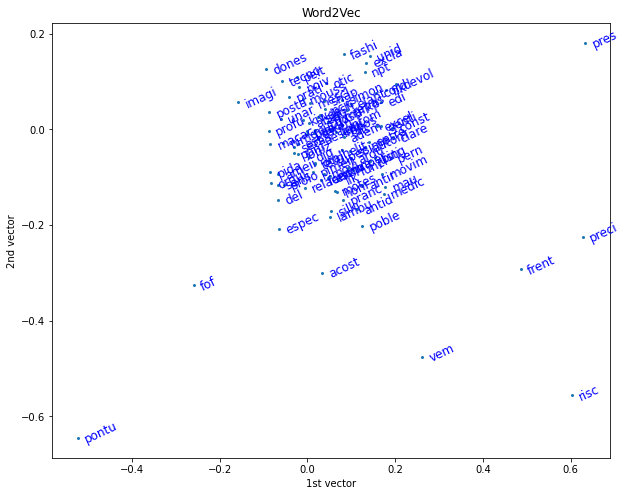

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))      
    
ax.plot(pca_df_100['V1'], pca_df_100['V2'], marker='o',
        linestyle='', markersize=2)


for _, value in pca_df_100.iterrows():
    ax.annotate(value['word'][0:5], (value['V1'], value['V2']),
                xytext=(5,-5), textcoords='offset points',
                rotation=25,
                family='sans-serif', fontsize=12,color='blue')
    
ax.set_title('Word2Vec')
ax.set_xlabel('1st vector')
ax.set_ylabel('2nd vector')

plt.show();

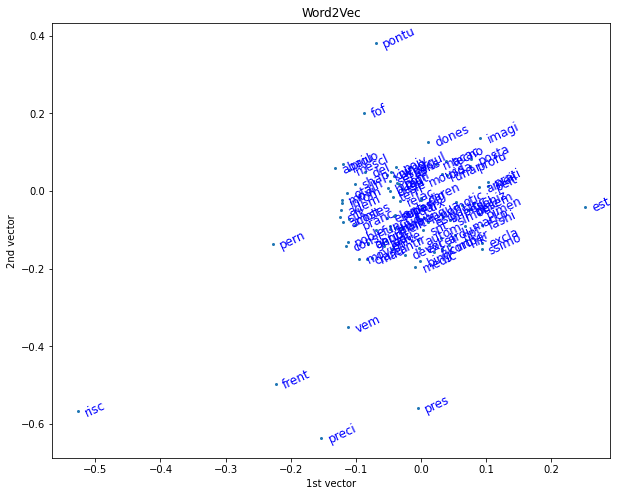

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))      
    
ax.plot(v_df_100['V1'], v_df_100['V2'], marker='o',
        linestyle='', markersize=2)


for _, value in v_df_100.iterrows():
    ax.annotate(value['word'][0:5], (value['V1'], value['V2']),
                xytext=(5,-5), textcoords='offset points',
                rotation=25,
                family='sans-serif', fontsize=12,color='blue')
    
ax.set_title('Word2Vec')
ax.set_xlabel('1st vector')
ax.set_ylabel('2nd vector')

plt.show();

In [ ]:
lr_result.groupBy('prediction').pivot('Sentiment').count().show()


+----------+--------+--------+
|prediction|negative|positive|
+----------+--------+--------+
|       0.0|    1891|     455|
|       1.0|    1237|    4537|
+----------+--------+--------+



In [ ]:
dtc_result.groupBy('prediction').pivot('Sentiment').count().show()


+----------+--------+--------+
|prediction|negative|positive|
+----------+--------+--------+
|       0.0|    1880|     507|
|       1.0|    1248|    4485|
+----------+--------+--------+



In [ ]:
rf_result.groupBy('prediction').pivot('Sentiment').count().show()

+----------+--------+--------+
|prediction|negative|positive|
+----------+--------+--------+
|       0.0|    1963|     510|
|       1.0|    1165|    4482|
+----------+--------+--------+



In [ ]:
nb_result.groupBy('prediction').pivot('Sentiment').count().show()


+----------+--------+--------+
|prediction|negative|positive|
+----------+--------+--------+
|       0.0|    1933|     568|
|       1.0|    1195|    4424|
+----------+--------+--------+



In [ ]:
lr_tp   = lr_result.filter('Sentiment == "positive" and prediction == 1').count()
lr_tn   = lr_result.filter('Sentiment == "negative" and prediction == 0').count()
lr_fp  = lr_result.filter('Sentiment == "negative" and prediction == 1').count()
lr_fn  = lr_result.filter('Sentiment == "positive" and prediction == 0').count()

dtc_tp   = dtc_result.filter('Sentiment == "positive" and prediction == 1').count()
dtc_tn   = dtc_result.filter('Sentiment == "negative" and prediction == 0').count()
dtc_fp  = dtc_result.filter('Sentiment == "negative" and prediction == 1').count()
dtc_fn  = dtc_result.filter('Sentiment == "positive" and prediction == 0').count()

rf_tp   = rf_result.filter('Sentiment == "positive" and prediction == 1').count()
rf_tn   = rf_result.filter('Sentiment == "negative" and prediction == 0').count()
rf_fp  = rf_result.filter('Sentiment == "negative" and prediction == 1').count()
rf_fn  = rf_result.filter('Sentiment == "positive" and prediction == 0').count()

nb_tp   = nb_result.filter('Sentiment == "positive" and prediction == 1').count()
nb_tn   = nb_result.filter('Sentiment == "negative" and prediction == 0').count()
nb_fp  = nb_result.filter('Sentiment == "negative" and prediction == 1').count()
nb_fn  = nb_result.filter('Sentiment == "positive" and prediction == 0').count()
#get true positive, true negative, false positive, false negative for logistic regression, decision tree, random forest and naive bayes
#13 min to run

['LR:', 4537, 1891, 1237, 455] ['DTC:', 4485, 1880, 1248, 507] ['RF:', 4482, 1963, 1165, 510] ['NB', 4424, 1933, 1195, 568]


In [ ]:
print('LR:','TP:',lr_tp,'TN:',lr_tn,'FP:',lr_fp,'FN:',lr_fn,'tpr:',lr_tp/(lr_tp+lr_fn),'tnr:',lr_tn/(lr_tn+lr_fp),'\n',
      'DTC:','TP:',dtc_tp,'TN:',dtc_tn,'FP:',dtc_fp,'FN:',dtc_fn,'tpr:',dtc_tp/(dtc_tp+dtc_fn),'tnr:',dtc_tn/(dtc_tn+dtc_fp),'\n',
      'RF:','TP:',rf_tp,'TN:',rf_tn,'FP:',rf_fp,'FN:',rf_fn,'tpr:',rf_tp/(rf_tp+rf_fn),'tnr:',rf_tn/(rf_tn+rf_fp),'\n',
      'NB','TP:',nb_tp,'TN:',nb_tn,'FP:',nb_fp,'FN:',nb_fn,'tpr:',nb_tp/(nb_tp+nb_fn),'tnr:',nb_tn/(nb_tn+nb_fp)
      )

LR: TP: 4537 TN: 1891 FP: 1237 FN: 455 tpr: 0.9088541666666666 tnr: 0.604539641943734 
 DTC: TP: 4485 TN: 1880 FP: 1248 FN: 507 tpr: 0.8984375 tnr: 0.6010230179028133 
 RF: TP: 4482 TN: 1963 FP: 1165 FN: 510 tpr: 0.8978365384615384 tnr: 0.6275575447570333 
 NB TP: 4424 TN: 1933 FP: 1195 FN: 568 tpr: 0.8862179487179487 tnr: 0.6179667519181585


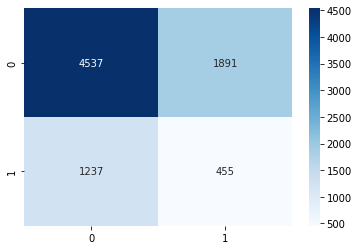

In [ ]:
lr_cm=[[lr_tp,lr_tn],[lr_fp,lr_fn]]
sn.heatmap(lr_cm, annot=True, cmap='Blues', fmt='d')
#confusion matrix for logistic regression

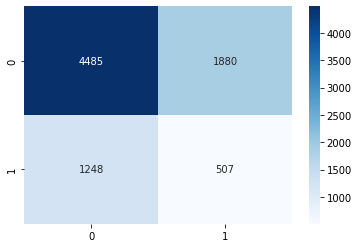

In [ ]:
dtc_cm=[[dtc_tp,dtc_tn],[dtc_fp,dtc_fn]]
sn.heatmap(dtc_cm, annot=True, cmap='Blues', fmt='d')
#confusion matrix for decision tree

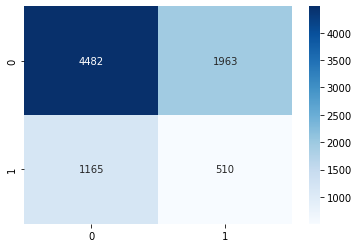

In [ ]:
rf_cm=[[rf_tp,rf_tn],[rf_fp,rf_fn]]
sn.heatmap(rf_cm, annot=True, cmap='Blues', fmt='d')
#confusion matrix for random forest

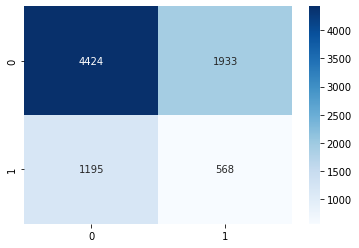

In [ ]:
nb_cm=[[nb_tp,nb_tn],[nb_fp,nb_fn]]
sn.heatmap(nb_cm, annot=True, cmap='Blues', fmt='d')
#confusion matrix for naive bayes

In [ ]:
spark.stop()

# Recommandation system
- Making recommandations for users
- Making recommandations for products

# Data preparation(Recomandation system)

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer, \
           StopWordsRemover, NGram, HashingTF, IDF, Word2Vec

from pyspark.sql.functions import explode, expr
from pyspark.ml.functions  import vector_to_array

In [ ]:
#imports
from google.colab import files
from pyspark import SparkContext 

from pyspark.sql.functions import expr
from pyspark.sql.functions import col,isnan,when,count
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import monotonically_increasing_id
import nltk

In [ ]:
!pwd

In [ ]:
#init spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(
    "RecSystem").getOrCreate()
spark


In [ ]:
## if show FileNotFoundError: [Errno 2] No such file or directory:
## https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

#**Collaborative Filtering**

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.Builder().master('local[*]')\
   .appName("Spark_ALS")\
   .getOrCreate()

spark

In [ ]:
from pyspark.ml.recommendation import ALS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#spark dataframe
df=spark.read.csv('/content/drive/MyDrive/Copy of retail_dataset.csv',
                  header=True,sep=',') #,header=True, inferSchema=True,sep=',', multiLine=True,
df.printSchema()

In [ ]:
df.show(5)

In [ ]:
d2 = df.select('customer_id','product_id','review_score')
d2.show(5)

In [ ]:
df.show(10)

In [ ]:
# total number of products

numProducts = d2.groupBy('product_id').count().count()
numProducts

In [ ]:
# total number of reviews 
d2.count()

In [ ]:
#data cleaning
#exclude na row
d3 = d2.na.drop()
d3.count()

In [ ]:
d3.show(5)

In [ ]:
# review counts by user

d3.groupBy('customer_id').count()\
        .orderBy('count', ascending=False).show(15)

In [ ]:
# ratings count by products

d3.groupBy('product_id').count()\
        .orderBy('count', ascending=False).show(15)

In [ ]:
d3.printSchema()

In [ ]:
s1 = d3.filter(d3['customer_id'].rlike('[\!\@\$\^\&\-\_\;\:\?\.\#\*]'))
s1.head(5)

In [ ]:
s2 = d3.filter(d3['product_id'].rlike('[\!\@\$\^\&\-\_\;\:\?\.\#\*]'))
s2.head(5)

In [ ]:
s3 = d3.filter(d3['review_score'].rlike('[\!\@\$\^\&\-\_\;\:\?\.\#\*]'))
s3.head(5)

All the columns have different types of characters in customer_id, product_id and review_score. We will drop these rows and check again. 

In [ ]:
#substracting these datrames from the original dataframe d3.
df3=d3.subtract(s1)
df3=df3.subtract(s2)
df3=df3.subtract(s3)

In [ ]:
df3.count()

In [ ]:
d3.count()

In [ ]:
df3.filter(df3['product_id'].rlike('[\!\@\$\^\&\-\_\;\:\?\.\#\*]')).head(5)

In [ ]:
df3.filter(df3['customer_id'].rlike('[\!\@\$\^\&\-\_\;\:\?\.\#\*]')).head(5)

In [ ]:
df3.filter(df3['review_score'].rlike('[\!\@\$\^\&\-\_\;\:\?\.\#\*]')).head(5)

In [ ]:
#Creating a copy of the dataframe
schema = df3.schema
df3_pd = df3.toPandas()
_df3 = spark.createDataFrame(df3_pd,schema=schema)
del df3_pd

In [ ]:
# review counts by user

t1 = df3.groupBy('customer_id').count()\
        .orderBy('count', ascending=False)

t1.tail(5)

In [ ]:
t1.count()

In [ ]:
dict1 = {row['customer_id']:row['id1'] for row in t11.collect()}


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

user_func =  udf (lambda x: dict1.get(x), IntegerType())
newdf = df3.withColumn('customer_id',user_func(df.customer_id))
newdf.show()

In [ ]:
t2 = df3.groupBy('product_id').count()\
        .orderBy('count', ascending=False)
t2.show()

In [ ]:
t22 = t2.withColumn("id2", monotonically_increasing_id())
t22.show()

In [ ]:
dict2 = {row['product_id']:row['id2'] for row in t22.collect()}
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

user_func =  udf (lambda x: dict2.get(x), IntegerType())
newdf_final = newdf.withColumn('product_id',user_func(df.product_id))
newdf_final.show()

In [ ]:
newdf_final.groupBy('review_score').count()\
        .orderBy('count', ascending=False).show(15)

In [ ]:
newdf_final.printSchema()

In [ ]:
df_final = newdf_final.withColumn("review_score", 
                                  newdf_final["review_score"]
                                  .cast('int'))
df_final.printSchema()

In [ ]:
df_final.count()

In [ ]:
training_data, test_data = df_final.randomSplit(
    [0.8,0.2], seed=1)

In [ ]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics

als = ALS(maxIter=10, regParam=0.01, 
          rank = 10,
          userCol="customer_id", 
          itemCol="product_id", 
          ratingCol="review_score",
          coldStartStrategy="drop")

model = als.fit(training_data)

In [ ]:
predictions = model.transform(test_data)

In [ ]:
predictions.show()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="review_score",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))

# **Product recommendations for users**


In [ ]:
als = ALS(maxIter=10, regParam=0.1, 
          rank = 2,
          userCol="customer_id", 
          itemCol="product_id", 
          ratingCol="review_score",
          coldStartStrategy="drop")

model = als.fit(df_final)

In [ ]:
model.userFactors

In [ ]:
model.userFactors.orderBy('id').show(10, truncate=False, vertical=True)


In [ ]:
user_1 = model.userFactors.filter('id =1').first()['features']
user_1

In [ ]:
model.itemFactors

In [ ]:
model.itemFactors.orderBy('id').show(5, truncate=False, vertical=True)

In [ ]:
import numpy as np
model.itemFactors.rdd.map(
    lambda x: (np.dot(x['features'], user_1), x['id']))\
        .takeOrdered(10, lambda x: -x[0])

In [ ]:
u = spark.createDataFrame([(0,)], schema=['customer_id'])
u.show()

In [ ]:
# Generate top 5 product recommendations for each user

userRecs = model.recommendForAllUsers(5)

userRecs

In [ ]:
userRecs.show(10, truncate=False, vertical=True)

#**User recommendations for Products**


In [ ]:
# Generate top 5 user recommendations for each movie

productRecs = model.recommendForAllItems(5)

productRecs

In [ ]:
productRecs.show(10, truncate=False, vertical=True)

In [ ]:
# Generate top 10 product recommendations for a specified set of users

users = df_final.select(als.getUserCol()).distinct().sample(False, 0.1, seed=1)
users.show()

In [ ]:
userSubsetRecs = model.recommendForUserSubset(users, 10)

userSubsetRecs.show(truncate=False, vertical=True)

In [ ]:
# Generate top 10 user recommendations for a specified set of products

products = df_final.select(als.getItemCol()).distinct().sample(False, 0.06, 1)
products.show()

In [ ]:
ProductSubSetRecs = model.recommendForItemSubset(products, 10)
ProductSubSetRecs.show(truncate=False, vertical=True)

In [ ]:
spark.stop()

#Creating user features using clustering techniques


In order to improve our model we want to look for common features among users and cluster them. The technique is meant to build a recommendation system within our current model. If the model is able to discern groupings for customers as a baseline to recommendations we can improve our model significantly.



In [ ]:
!pip install pyspark

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Load master dataframe

In [ ]:
master_df = pd.read_csv('/content/drive/MyDrive/Spark/master_df.txt', sep = ',', index_col=0)

FileNotFoundError: ignored

In [ ]:
master_df.tail()

,order_id,customer_id,order_purchase_timestamp,order_item_id,product_id,seller_id,price,review_score,review_comment_message,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_photos_qty,product_weight_g,seller_zip_code_prefix,seller_city,seller_state
152805,fc703730f6206ec478cae91c89f7dcb3,d99700792f0811f23d94f2edb64634f8,2018-07-28 18:01:11,1,47d4f578b4130f61735dcfb66c38cb5e,0be8ff43f22e456b4e0371b2245e4d01,39.90,4,no comment given,8b8c8f067a3faaf116211277147a88de,35494,desterro de entre rios,MG,sports_leisure,2.0,750.0,4461,sao paulo,SP
152806,f1a1942c32bd91ad8368164ae571b8f7,9632f1ff07591588a9596b99f8515c03,2018-04-16 20:51:56,1,03d463c3dea9d1650ce0683b7c964b03,ea8482cd71df3c1969d7b9473ff13abc,21.99,4,Recomendo,1ef6a1d949703afd7a74347aed3b0503,77413,gurupi,TO,telephony,5.0,350.0,4160,sao paulo,SP
152807,ff64e0ba4800eb1127ac32aeac2b51f9,16482587049b0c2a607dd532d0653696,2017-11-20 16:46:51,1,9a3ba846b3c74a316408ccf07a40374b,26d8a1c7c75d513045798992ead43aa2,129.99,4,no comment given,ebc6df639d125e446f07c0e9b1e47b90,32250,contagem,MG,perfumery,3.0,505.0,86800,apucarana,PR
152808,ada8de3a9486cea2fce7f4b00319cf3c,9065a96b91a08c08755c4ea2618884f2,2018-07-09 18:25:16,1,77b00b27cdf648f59626359c392cee1d,7142540dd4c91e2237acb7e911c4eba2,99.90,5,Eu gostei de comprar sim chegou no prazo certo,ed81a42bec90c87578108d2e4c742d20,44798,umburanas,BA,auto,6.0,650.0,16301,penapolis,SP
152809,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,2017-12-20 09:52:41,1,3d2c44374ee42b3003a470f3e937a2ea,ce248b21cb2adc36282ede306b7660e5,55.90,1,"Ele não é um mini cajon, é um shaker, ou seja,...",a49e8e11e850592fe685ae3c64b40eca,83870,campo do tenente,PR,musical_instruments,2.0,300.0,89251,jaragua do sul,SC


In [ ]:
#Dropping the duplicates from order_id,order_item_id columns and removing null values from the dataset
master_df = master_df.drop_duplicates(['order_id', 'order_item_id']).dropna().reset_index(drop=True)

In [ ]:
master_df.product_category_name.value_counts()[:20]


bed_bath_table              10925
health_beauty                9438
sports_leisure               8412
furniture_decor              8137
computers_accessories        7622
housewares                   6777
watches_gifts                5835
telephony                    4400
garden_tools                 4256
auto                         4130
toys                         3995
cool_stuff                   3672
perfumery                    3325
baby                         2972
electronics                  2636
stationery                   2452
fashion_bags_accessories     1978
pet_shop                     1903
office_furniture             1662
consoles_games               1085
Name: product_category_name, dtype: int64

#Create user product interaction

In [ ]:
item_features = master_df[['customer_unique_id', 'customer_id','product_id', 'order_id', 'product_category_name', 'order_item_id', 'seller_id', 'review_score', 
                          'review_comment_message', 'seller_city', 'seller_state', 'price']]

In [ ]:
item_features.head(5)

,customer_unique_id,customer_id,product_id,order_id,product_category_name,order_item_id,seller_id,review_score,review_comment_message,seller_city,seller_state,price
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,e481f51cbdc54678b7cc49136f2d6af7,housewares,1,3504c0cb71d7fa48d967e0e4c94d59d9,4,"Não testei o produto ainda, mas ele veio corre...",maua,SP,29.99
1,e781fdcc107d13d865fc7698711cc572,53904ddbea91e1e92b2b3f1d09a7af86,87285b34884572647811a353c7ac498a,bfc39df4f36c3693ff3b63fcbea9e90a,housewares,1,3504c0cb71d7fa48d967e0e4c94d59d9,3,no comment given,maua,SP,29.99
2,3a51803cc0d012c3b5dc8b7528cb05f7,a20e8105f23924cd00833fd87daa0831,87285b34884572647811a353c7ac498a,128e10d95713541c87cd1a2e48201934,housewares,1,3504c0cb71d7fa48d967e0e4c94d59d9,4,Deveriam embalar melhor o produto. A caixa vei...,maua,SP,29.99
3,ef0996a1a279c26e7ecbd737be23d235,26c7ac168e1433912a51b924fbd34d34,87285b34884572647811a353c7ac498a,0e7e841ddf8f8f2de2bad69267ecfbcf,housewares,1,3504c0cb71d7fa48d967e0e4c94d59d9,5,"Só achei ela pequena pra seis xícaras ,mais é ...",maua,SP,29.99
4,8a4002923e801e3120a11070fd31c9e2,8e8ee9b08afb49b080d193f98b0505af,6cc44821f36f3156c782da72dd634e47,70b35acffdf851e782ebf6fbc35eb620,bed_bath_table,1,da8622b14eb17ae2831f4ac5b9dab84a,5,Nâo sabia da entrega aos domingos pelo correio...,piracicaba,SP,99.90


In [ ]:
item_features[['product_category_name', 'customer_unique_id', 'order_item_id']]

,product_category_name,customer_unique_id,order_item_id
0,housewares,7c396fd4830fd04220f754e42b4e5bff,1
1,housewares,e781fdcc107d13d865fc7698711cc572,1
2,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,1
3,housewares,ef0996a1a279c26e7ecbd737be23d235,1
4,bed_bath_table,8a4002923e801e3120a11070fd31c9e2,1
...,...,...,...
108105,sports_leisure,8b8c8f067a3faaf116211277147a88de,1
108106,telephony,1ef6a1d949703afd7a74347aed3b0503,1
108107,perfumery,ebc6df639d125e446f07c0e9b1e47b90,1
108108,auto,ed81a42bec90c87578108d2e4c742d20,1


In [ ]:
# Create product_count column for the rating
item_features['product_category_count'] = item_features[['product_category_name', 'customer_unique_id', 'order_item_id']]\
                                                            .groupby(['customer_unique_id', 'product_category_name'])['order_item_id']\
                                                            .transform('count')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
item_features[['product_category_name', 'customer_unique_id', 'product_category_count']]

,product_category_name,customer_unique_id,product_category_count
0,housewares,7c396fd4830fd04220f754e42b4e5bff,1
1,housewares,e781fdcc107d13d865fc7698711cc572,1
2,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,1
3,housewares,ef0996a1a279c26e7ecbd737be23d235,1
4,bed_bath_table,8a4002923e801e3120a11070fd31c9e2,2
...,...,...,...
108105,sports_leisure,8b8c8f067a3faaf116211277147a88de,1
108106,telephony,1ef6a1d949703afd7a74347aed3b0503,1
108107,perfumery,ebc6df639d125e446f07c0e9b1e47b90,1
108108,auto,ed81a42bec90c87578108d2e4c742d20,1


In [ ]:
user_to_product_category = item_features[['product_category_name', 'customer_unique_id', 'product_category_count']]\
                                        .sort_values(by='customer_unique_id')\
                                        .reset_index(drop=True)

In [ ]:
user_to_product_category['product_count'] = 1

In [ ]:
user_to_product_category = user_to_product_category.drop(['product_category_count'], axis=1)

In [ ]:
def get_user_list(df, user_column):
    """
    
    creating a list of user from dataframe df, user_column is a column 
    consisting of users in the dataframe df
    
    """
    
    return np.sort(df[user_column].unique())

def get_item_list(df, item_name_column):
    
    """
    
    creating a list of items from dataframe df, item_column is a column 
    consisting of items in the dataframe df
    
    return to item_id_list and item_id2name_mapping
    
    """
    
    item_list = df[item_name_column].unique()
    
    
    return item_list

In [ ]:
def id_mappings(user_list, item_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    for user_index, user_id in enumerate(user_list):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(item_list):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        

    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping

In [ ]:
from scipy import sparse
def get_interaction_matrix(df, df_column_as_row, df_column_as_col, df_column_as_value, row_indexing_map, 
                          col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return sparse.coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

In [ ]:
user_list = get_user_list(user_to_product_category, 'customer_unique_id')
item_list = get_item_list(user_to_product_category, 'product_category_name')

In [ ]:
user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping = id_mappings(user_list, item_list)

In [ ]:
user_to_product_category_interaction = get_interaction_matrix(user_to_product_category, "customer_unique_id", 
                                                           "product_category_name", "product_count", 
                                                           user_to_index_mapping, item_to_index_mapping)

In [ ]:
product_category_to_user_interaction = get_interaction_matrix(user_to_product_category, "product_category_name", 
                                                             "customer_unique_id", "product_count",
                                                             item_to_index_mapping, user_to_index_mapping)

#User clustering


Clustering will be conducted using kmeans which uses distance based algorithms to decide clusters using maximum marginality between edge cases.

In [ ]:
import scipy.sparse

table = pd.DataFrame(user_to_product_category_interaction.todense())

In [ ]:
table1 = pd.DataFrame(product_category_to_user_interaction.todense())

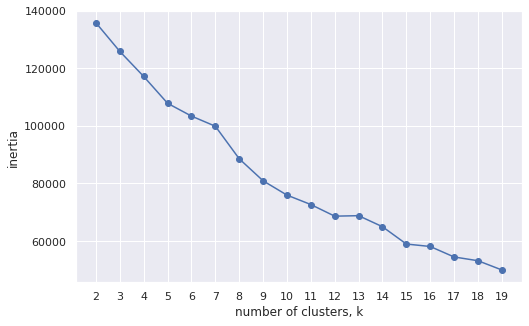

In [ ]:
from sklearn.cluster import KMeans

# Create table of values only
x_cols = table.values
ks = range(2, 20)
inertias = []

for k in ks:
    # create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters = k, random_state=3)
    # fit model to samples
    kmeans.fit(x_cols)
    # append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)

# plot ks vs inertias
plt.figure(figsize=(8,5))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

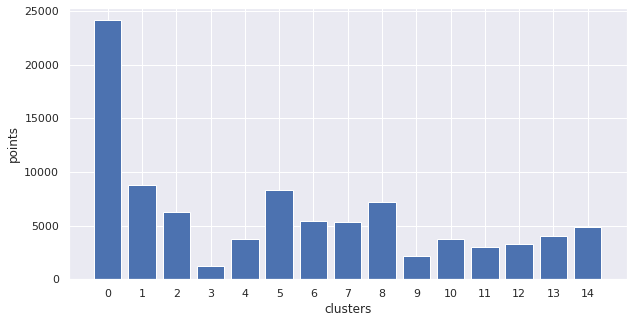

In [ ]:
from sklearn.cluster import KMeans
x_cols = table.values
# create a KMeans instance with k clusters
model = KMeans(n_clusters = 15, random_state=3)
# fit model to samples
model.fit(x_cols)
# Create labels for data
labels = model.predict(x_cols)

# create bar chart
clusters, npoints = np.unique(labels, return_counts=True)
plt.figure(figsize=(10,5))
plt.bar(clusters, npoints)
plt.xticks(clusters)
plt.ylabel('points')
plt.xlabel('clusters')
plt.show()

In [ ]:
labels = pd.DataFrame({'cluster_id': labels})

In [ ]:
table.index.name = 'customer_unique_id'

In [ ]:
table = table.reset_index()

In [ ]:
df = pd.concat([table.customer_unique_id, \
                labels], axis=1, sort=False)

In [ ]:
df = df.replace({"customer_unique_id": index_to_user_mapping})

In [ ]:
df.head()

,customer_unique_id,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5
2,0000f46a3911fa3c0805444483337064,9
3,0000f6ccb0745a6a4b88665a16c9f078,13
4,0004aac84e0df4da2b147fca70cf8255,13


In [ ]:
item_features_clustered = item_features.merge(df, on = 'customer_unique_id')

In [ ]:
item_features_clustered.to_csv(r'/content/drive/MyDrive/Spark/item_features_clustered.csv')

Following this we will group the product descriptions into bins to generalize for the model using pandas cut and qcut.

#Create user-item and item feature dataframes


In [ ]:
user_item = master_df[['customer_id', 'customer_unique_id', 'product_id', 'review_score', 'order_purchase_timestamp']]
user_features = master_df[['customer_unique_id', 'customer_city', 'customer_state']]
item_features = master_df[['customer_unique_id','product_id', 'customer_id', 'product_category_name', 'seller_id', 'review_score', 
                          'review_comment_message', 'seller_city', 'seller_state', 'price', 'order_id', 'order_item_id']]

In [ ]:
item_features = item_features.drop_duplicates(['customer_id','order_id', 'order_item_id']).reset_index(drop=True)

#Create aggregated columns to improve product features


In [ ]:
# to avoid counting a review comment labeled 'no comment given', we will convert them back to NAN
item_features['review_comment_message'] = item_features.review_comment_message\
                                                               .replace('no comment given', np.nan)

# create average review score column 
item_features['avg_product_score'] = item_features['review_score']\
                                                                 .groupby(item_features['product_id'])\
                                                                 .transform('mean')
# create average review score column 
item_features['avg_seller_score'] = item_features['review_score']\
                                                                 .groupby(item_features['seller_id'])\
                                                                 .transform('mean')

# create average review score column 
item_features['num_comments'] = item_features['review_comment_message']\
                                                                       .groupby(item_features['product_id'])\
                                                                       .transform('count')

# create average review score column 
item_features['num_reviews'] = item_features['review_score']\
                                                            .groupby(item_features['product_id'])\
                                                            .transform('count')

In [ ]:
# create average price column
item_features['avg_price'] = item_features[['price']]\
                                                     .groupby(item_features['product_id'])\
                                                     .transform('mean')

In [ ]:
# Create product_count column for the rating
item_features['product_count'] = item_features['product_id']\
                                                            .groupby(item_features['customer_unique_id'])\
                                                            .transform('count')

#Transform columns to improve distance based algorithms used in clustering, to be performed in seperate notebook


In [ ]:
item_features['log_avg_price'] = np.log1p(item_features['avg_price'])

In [ ]:
item_features['log_num_reviews'] = np.log1p(item_features['num_reviews'])
item_features['log_num_comments'] = np.log1p(item_features['num_comments'])

In [ ]:
# use cut to group the same number of reviews in each section
item_features['num_reviews_binned'] = pd.cut(item_features['log_num_reviews'], 7, duplicates = 'drop')
item_features['num_comments_binned'] = pd.cut(item_features['log_num_comments'], 6, duplicates = 'drop')

# 
item_features['avg_product_reviews_binned'] = pd.cut(item_features['avg_product_score'], 4, duplicates = 'drop')
item_features['avg_seller_reviews_binned'] = pd.cut(item_features['avg_seller_score'], 4, duplicates = 'drop')

item_features['avg_price_binned'] = pd.qcut(item_features['avg_price'], 4, duplicates = 'drop')

In [ ]:
item_features = item_features.sort_values('customer_unique_id').reset_index(drop=True)

In [ ]:
cols = ['num_reviews_binned', 'num_comments_binned','avg_product_reviews_binned', 
        'avg_seller_reviews_binned', 'avg_price_binned']
for col in cols:
    item_features[col] = item_features[col].astype(str)

In [ ]:
# Save item features to csv to be pulled and used in notebook for clustering
item_features.to_csv(r'/content/drive/MyDrive/Spark/item_features.csv', index=True)

# Spark Recommender System ALS
ALS does a good job of using collaborative techniques to make a prediction.

The algorithm uses alternating least squares as a metric for optimizing predictions of a users preference for an item. How it does it is by taking the original matrix of users and product ratings R, which in our case is the number of times a user bought an item for a given product, and factorizes it into two matrices U and P. When U and P are multiplied back together the empty ratings will be replaced with an estimation. The alternating part of ALS comes from the way the algorithm minimizes least squares error. It will alternate between matrices U and P by fixing one matrix and optimizing for the other and then repeating this process a designated number of times to minimize least squared error. The resulting matrix will have ratings filled in for each product. We will tune our model by estimating our parameters and iterating until an optimal root mean squared error is achieved.

In [ ]:
# !pip install pyspark

In [ ]:
# import necessary modules
import os
import shutil
import pyspark as ps
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql import Row
from pyspark.sql.types import DoubleType

In [ ]:
# create spark context
spark = (ps.sql.SparkSession.builder
        .appName("sandbox")
        .getOrCreate()
        )
sc = spark.sparkContext
print(spark.version)

3.2.1


#Read in Data


We will use user clusters as part of user features for our model here.



In [ ]:

data_dir = os.path.join("/content/drive/MyDrive/Spark/", "")

file = os.path.join(data_dir,"item_features_clustered.csv")

# options are specified to read in data without error
df_user = spark.read.format("csv")\
               .option("multiline", "true")\
               .option("quote", '"')\
               .option("header", "true")\
               .option("escape", "\\")\
               .option("escape", '"')\
               .load(file)

In [ ]:
file = os.path.join(data_dir, "item_features.csv")

# options are specified to read in data without error
df_item = spark.read.format("csv")\
               .option("multiline", "true")\
               .option("quote", '"')\
               .option("header", "true")\
               .option("escape", "\\")\
               .option("escape", '"')\
               .load(file)

#Create use and item feature matrices


In [ ]:
user_features = df_user.select(df_user['customer_unique_id'], 
                               df_user['product_id'], 
                               df_user['product_category_count'])

In [ ]:
user_features.show(4)

+--------------------+--------------------+----------------------+
|  customer_unique_id|          product_id|product_category_count|
+--------------------+--------------------+----------------------+
|7c396fd4830fd0422...|87285b34884572647...|                     1|
|7c396fd4830fd0422...|9abb00920aae319ef...|                     1|
|e781fdcc107d13d86...|87285b34884572647...|                     1|
|3a51803cc0d012c3b...|87285b34884572647...|                     1|
+--------------------+--------------------+----------------------+
only showing top 4 rows



In [ ]:
user_features = user_features.sort("customer_unique_id")

In [ ]:
item_features = df_item.select(df_item['product_id'], 
                               df_item['product_category_name'], 
                               df_item['avg_price_binned'])

In [ ]:
item_features.show(4)

+--------------------+---------------------+----------------+
|          product_id|product_category_name|avg_price_binned|
+--------------------+---------------------+----------------+
|372645c7439f9661f...|       bed_bath_table|   (74.9, 135.0]|
|5099f7000472b634f...|        health_beauty|   (0.849, 39.9]|
|64b488de448a5324c...|           stationery|    (39.9, 74.9]|
|2345a354a6f203360...|            telephony|   (0.849, 39.9]|
+--------------------+---------------------+----------------+
only showing top 4 rows



#Index user and product ids


In [ ]:
from pyspark.ml.feature import StringIndexer

# create object of StringIndexer class and specify input and output column
SI_customer = StringIndexer(inputCol='customer_unique_id',outputCol='customer_index')
SI_product = StringIndexer(inputCol='product_id',outputCol='product_index')

# transform the data
user_features = SI_customer.fit(user_features).transform(user_features)
user_features = SI_product.fit(user_features).transform(user_features)
item_features = SI_product.fit(item_features).transform(item_features)

# view the transformed data
user_features.select('customer_unique_id', 'customer_index', 'product_id', 'product_index').show(10)
item_features.select('product_id', 'product_index').show(10)

+--------------------+--------------+--------------------+-------------+
|  customer_unique_id|customer_index|          product_id|product_index|
+--------------------+--------------+--------------------+-------------+
|0000366f3b9a7992b...|       11367.0|372645c7439f9661f...|        376.0|
|0000b849f77a49e4a...|       11368.0|5099f7000472b634f...|       2692.0|
|0000f46a3911fa3c0...|       11369.0|64b488de448a5324c...|       4076.0|
|0000f6ccb0745a6a4...|       11370.0|2345a354a6f203360...|       6466.0|
|0004aac84e0df4da2...|       11371.0|c72e18b3fe2739b8d...|      27745.0|
|0004bd2a26a76fe21...|       11372.0|25cf184645f3fae66...|       6480.0|
|00050ab1314c0e55a...|       11373.0|8cefe1c6f2304e7e6...|       2337.0|
|00053a61a98854899...|        2748.0|62984ea1bba7fcea1...|       5229.0|
|00053a61a98854899...|        2748.0|58727e154e8e85d84...|       1329.0|
|0005e1862207bf6cc...|       11374.0|e24f73b7631ee3fbb...|        937.0|
+--------------------+--------------+--------------

In [ ]:
from pyspark.sql.types import IntegerType
# convert columns to integer types
user_features = user_features.withColumn("product_category_count",
                                        user_features["product_category_count"].cast(IntegerType()))

#Model Training


In [ ]:
# split 80-20
(training, test) = user_features.randomSplit([0.8, 0.2])

In [ ]:
# train the recommender with als
als_alg = ALS(maxIter=5, 
              regParam=0.01, 
              userCol='customer_index', 
              itemCol="product_index", 
              ratingCol='product_category_count',
              coldStartStrategy='drop', 
              seed = 3)

model=als_alg.fit(training)

# evaluate with the holdout set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='product_category_count',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)

print("Root-mean-squared-error = " + str(round(rmse, 3)))

Root-mean-squared-error = 0.551


#Generate user and product recommendations

These can be sampled from to output predictions for specific users.



In [ ]:
# generate top 5 product recommendations for user
user_recs = model.recommendForAllUsers(5)
user_recs.show(4)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------+--------------------+
|customer_index|     recommendations|
+--------------+--------------------+
|             1|[{1621, 20.999475...|
|             3|[{345, 19.999603}...|
|             5|[{983, 14.999268}...|
|             6|[{3111, 15.004645...|
+--------------+--------------------+
only showing top 4 rows



In [ ]:
product_recs = model.recommendForAllItems(10)
product_recs.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------------+--------------------+
|product_index|     recommendations|
+-------------+--------------------+
|            1|[{7, 13.979937}, ...|
|            3|[{55, 7.817689}, ...|
|            5|[{55, 7.944612}, ...|
|            6|[{62, 2.1343553},...|
|            9|[{368, 4.980856},...|
|           12|[{368, 4.6353884}...|
|           13|[{539, 6.740046},...|
|           15|[{7, 8.555045}, {...|
|           16|[{92, 3.2450156},...|
|           17|[{97, 8.690315}, ...|
|           19|[{368, 2.1663835}...|
|           20|[{368, 3.2024944}...|
|           22|[{976, 3.8312364}...|
|           26|[{62, 7.732267}, ...|
|           27|[{55, 2.699441}, ...|
|           28|[{368, 5.826364},...|
|           31|[{2685, 2.986154}...|
|           34|[{841, 3.9869564}...|
|           35|[{55, 10.442018},...|
|           37|[{55, 7.524214}, ...|
+-------------+--------------------+
only showing top 20 rows



In [ ]:
users = user_features.select(als_alg.getUserCol()).distinct().limit(3)
user_subset_recs = model.recommendForUserSubset(users, 10)
user_subset_recs.show(n=4)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------+--------------------+
|customer_index|     recommendations|
+--------------+--------------------+
|         11430|[{1053, 4.4198475...|
|         11766|[{1053, 6.326797}...|
|         11757|[{345, 6.7006454}...|
+--------------+--------------------+

